# Solving an inverse Problem with TorchPhysics and PINNs: Example 8
We consider now the wave equation

\begin{align*}
    \partial_t^2 u &= {\color{red}{c}} \, \partial_x^2 u, &&\text{ in } I_x \times I_t, \\
    u &= 0 , &&\text{ on } \partial I_x \times I_t, \\
    (\partial_t u)(\cdot, 0) &= 0 , &&\text{ in } I_x, \\
    u(\cdot, 0) &= \sin(x) , &&\text{ in } I_x,
\end{align*}

with $I_x = [0, 2\pi]$ and $I_t = [0, 5]$. We are given a noisy dataset $\{(u_i, x_i, t_i)\}_{i=1}^N$ and aim to determine the corresponding value of $\color{red}{c}$.

The data condition already enforces the correct shape of $u$, including boundary and initial conditions. Since $\color{red}{c}$ is exclusively present in the PDE loss, we decide to not include the boundary and initial conditions as additional loss terms but train only on the PDE and data condition. Hence, the models for $u$ and $\color{red}{c}$ will be trained to minimize: 
\begin{align*}
\text{Data loss} + \text{PDE loss} = \frac{1}{N}\sum_{i=1}^N \vert u_i - u(x_i, t_i) \vert^2 + \frac{1}{M}\sum_{j=1}^M \vert \partial_t^2 u(\tilde{x}_j, \tilde{t}_j) - {\color{red}{c}} \, \partial_x^2 u(\tilde{x}_j, \tilde{t}_j) \vert^2 
\end{align*}

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
if user <= 21: 
    gpu_device = str(user % 7) # moriarty
else: gpu_device = str(user % 4) # neptuno
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

In [2]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math

# Here, the bounds for intervals are defined:
t_min, t_max = 0.0, 5.0 # Bounds for interval I_t
x_min, x_max = 0.0, 2 * math.pi # Bounds for interval I_x

### Spaces, domains and samplers

In [3]:
# First, we define all spaces occuring in the formulation of the PDE. For the parameter c, we also need to define a (one-dimensional) space.
X = tp.spaces.R1('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
C = tp.spaces.R1('c')

# TODO: Define the interval domains for space and time.
I_x = tp.domains.Interval(X, x_min, x_max)
I_t = tp.domains.Interval(T, t_min, t_max)

# TODO: Create random uniform sampler for the PDE condition inside I_x x I_t.
#       The sampler should sample 15000 points per iteration.
pde_sampler = tp.samplers.RandomUniformSampler(I_x * I_t, n_points=15000)

### Load dataset $\{(u_i, x_i, t_i)\}_{i=1}^N$

In [ ]:
in_data = torch.load('../SolutionData/Ex_8/wave_in_data.pt')
out_data = torch.load('../SolutionData/Ex_8/wave_out_data.pt')

In [5]:
# TODO: Add around 1% random noise to the output data.
# Hint: torch.rand_like(a) creates random uniform noise with the same shape as a.
noise = 0.01 * torch.rand_like(out_data) # modify...
out_data_noisy = out_data + noise

# Check noise level
noise_level = 100 * torch.norm(out_data_noisy - out_data) / torch.norm(out_data)
print(f'Noise level is {torch.round(noise_level)} %')

Noise level is 1.0 %


In [6]:
# In order to work with the data in TorchPhysics,
# we need to transform the data into `tp.spaces.Points` objects.
in_data_points = tp.spaces.Points(in_data, space=X*T)

# TODO: Similarly, create points for the noisy output data.
#       Which torchphysics space should be specified for the output data?
out_data_points = tp.spaces.Points(out_data_noisy, U)

# Here we create a DataLoader, that passes the above data to the conditions and
# also controls the batch size, the device (CPU or GPU) and more...
data_loader = tp.utils.PointsDataLoader((in_data_points, out_data_points), batch_size=len(in_data))

### Proceed with familiar TorchPhysics pipeline: Create models, residual functions and conditions

In [7]:
# TODO: For the model u, fill in the correct input and output spaces.
model_u = tp.models.FCN(input_space=X*T, output_space=U, hidden = (50,50,50))

# TODO: Create the learnable parameter c. For that, use `tp.models.Parameter`.
#       You need to specify an initial value of the parameter,
#                           and the space of the parameter.
param_C = tp.models.Parameter(1.0, C)

In [8]:
# TODO: Define residual function for the PDE:
def pde_residual(c, u, t, x):
    return tp.utils.laplacian(u, t) - c * tp.utils.laplacian(u, x)

# TODO: Define the corresponding PINNCondition. It should now also take the learnable parameter c as input to optimize it alongside the model u.
pde_condition = tp.conditions.PINNCondition(model_u, pde_sampler, pde_residual, parameter=param_C)

A DataCondition minimizes the distance between the outputs of the NN u and the given data points u_i.

In [9]:
# For the data condtion, the main inputs are:
# the model u,
# the data loader that we created above,
# the norm for measuring the distance between the model's output and data. norm=2 stands for the l2-norm.
data_condition = tp.conditions.DataCondition(module=model_u,
                                             dataloader=data_loader,
                                             norm=2,
                                             use_full_dataset=True,
                                             weight=50)

### First, we optimize using the Adam optimizer.

In [ ]:
# Training parameters
train_iterations = 3000
learning_rate = 1.e-3

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[data_condition, pde_condition], optimizer_setting=optim)


trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=train_iterations, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False)

trainer.fit(solver)

In [11]:
# Show learned parameter. For plots/animation of the solution function u, see the code block after the LBFGS optimizer below.
print("Correct value of c is: 0.742")
print("With PINNs we computed the value:", param_C.as_tensor.item())
print("Relative difference is:", abs(0.742 - param_C.as_tensor.item()) / 0.742)

Correct value of c is: 0.742
With PINNs we computed the value: 0.7213603258132935
Relative difference is: 0.027816272488822825


Optional: try to improve the results by using LBFGS, a second-order optimizer that works only with constant inputs in every iteration.

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, optimizer_args={'max_iter': 3})
pde_condition.sampler = pde_condition.sampler.make_static()
solver = tp.solver.Solver([pde_condition, data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     max_steps=500,
                     logger=False,
                     benchmark=True,
                     enable_checkpointing=False)

trainer.fit(solver)

In [13]:
print("Correct value of c is: 0.742")
print("With PINNs we computed the value:", param_C.as_tensor.item())
print("Relative difference is:", abs(0.742 - param_C.as_tensor.item()) / 0.742)

Correct value of c is: 0.742
With PINNs we computed the value: 0.7325037121772766
Relative difference is: 0.012798231567012644


### Visualize learned solution u

/localdata/komso/komso01/.local/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


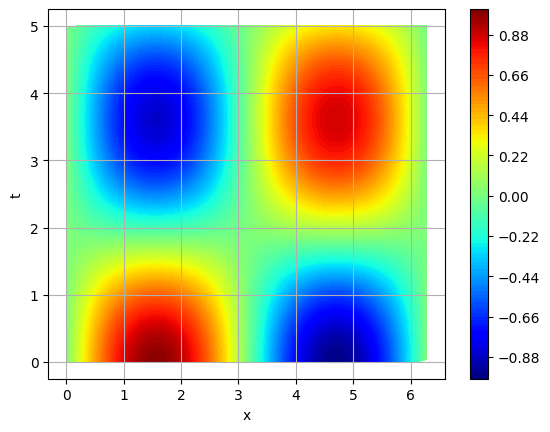

In [14]:
# We can also plot the solution that we learned
plot_domain = tp.domains.Parallelogram(X*T, [0, 0], [x_max, 0], [0, t_max])
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, plot_type="contour_surface")
#plt.savefig('inv_wave')

MovieWriter ffmpeg unavailable; using Pillow instead.


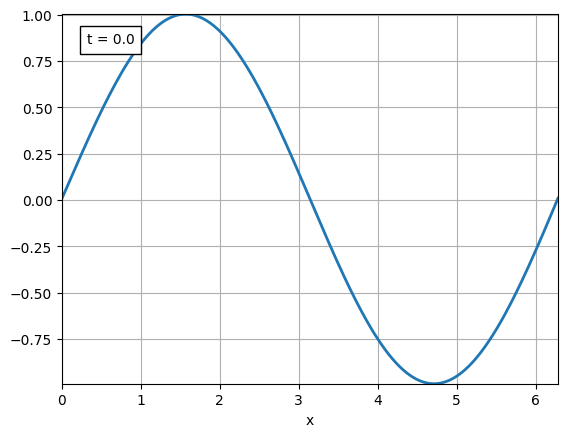

In [15]:
# Or an animation:
anim_sampler = tp.samplers.AnimationSampler(I_x, I_t, 200, n_points=250)
fig, anim = tp.utils.animate(model_u, lambda u: u, anim_sampler, ani_speed=40)
anim.save('wave-eq.gif')
# On the left side of JupyterHub, there is a tab with a folder. Therin, you should find the gif and can watch it.